# Square J1-J2 model

In this tutorial, we use neural quantum states and variational Monte Carlo to study the J1-J2 Heisenberg model on the square lattice.

We will work on the 4x4 lattice. Due to the spin conservation in the Heisenberg interactions, we limit the number of both up and down spins to 8.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import quantax as qtx
from IPython.display import clear_output

# 4x4 square lattice, 8 spin-up, 8 spin-down
lattice = qtx.sites.Square(4, Nparticles=(8, 8))
N = lattice.Nsites

The Hamiltonian is

$$
H = J_1 \sum_{\braket{ij}} \mathbf{\sigma}_i \cdot \mathbf{\sigma}_j
+ J_2 \sum_{\braket{\braket{ij}}} \mathbf{\sigma}_i \cdot \mathbf{\sigma}_j,
$$

where $\braket{ij}$ and $\braket{\braket{ij}}$ represent nearest and next-nearest neighbors, respectively. 

## Heisenberg model

A nearest-neighbor Heisenberg model has $J_1=1$ and $J_2=0$. In this special case, the exact sign structure of the model is given by the Marshall sign rule. In the code below, `msr=True` encodes this sign structure by rotating the local basis of the Hamitltonian, such that its ground state wavefunctions are positive in the new basis.

In [2]:
H = qtx.operator.Heisenberg(msr=True)

In this function, we define $J_1 = 1$ and $J_2 = 0.5$. The neighbors are determined by the distance of spins in real space. With `msr=True`, the function returns a Hamiltonian corrected by Marshall sign rule (MSR), which is equivalent to the original J1-J2 model but has simpler sign structures.

In this small lattice, one can use exact diagonalization to obtain the reference energy. 

In [3]:
from quantax.symmetry import TransND, Rotation, Flip, SpinInverse

full_symm = TransND() @ Rotation(np.pi/2) @ Flip() @ SpinInverse()
# full_symm = TransND() + Rotation(np.pi/2) + Flip() + SpinInverse()
E, wf = H.diagonalize(full_symm)
exact_energy = E[0]
print(f"Exact ground state energy: {exact_energy}")

/home/aochen/quantax_env/lib/python3.12/site-packages/quantax/symmetry/symmetry.py:288: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  basis = spin_basis_general(


Exact ground state energy: -44.91393283371544


We can utilize a pre-defined ResNet for solving this Hamiltonian. By default, its output wavefunctions are strictly positive. Here we define a residual convolutional network with 2 blocks, 8 channels and 3x3 kernels.

In [4]:
model = qtx.model.ResConv(nblocks=2, channels=8, kernel_size=3)

In Quantax, we usually define a variational state by `state = qtx.state.Variational(model)`. Here we should be careful about one more thing - the batch size. There are two benefits to set a maximum batch size in the forward pass.

1. Sometimes the forward batch is too large and can cause an out-of-memory error. Set a maximum batch size can force the batch to be splitted into smaller pieces and forwarded piece by piece to avoid the memory bottleneck.

2. When computing the local energy $E_\mathrm{loc}(s) = \sum_{s'} H_{ss'} \psi(s')/\psi(s)$ in systems like the Heisenberg model, the number of nonzero $H_{ss'}$ depends on $s$. A direct computation of $\psi(s')$ involves non-constant length and triggers re-jitting. When a maximum batch size is given, Quantax will pad the number of $s'$ to a multiple of batch size to avoid re-jitting.

In [8]:
state = qtx.state.Variational(model, max_parallel=25000)

Here the forward and backward batch sizes are both set to 16384. You can also set them to different values by giving a tuple like `max_parallel=(25000, 2048)`. When running on multiple devices, the batch given here is the size on __each machine__. For example, the actual batch size on all machines is 8*25000 if you are running your code on 8 GPUs.

Then we can define the Monte Carlo sampler and SR optimizer for training the state.

In [9]:
sampler = qtx.sampler.SpinExchange(state, nsamples=1024)
optimizer = qtx.optimizer.SR(state, H)

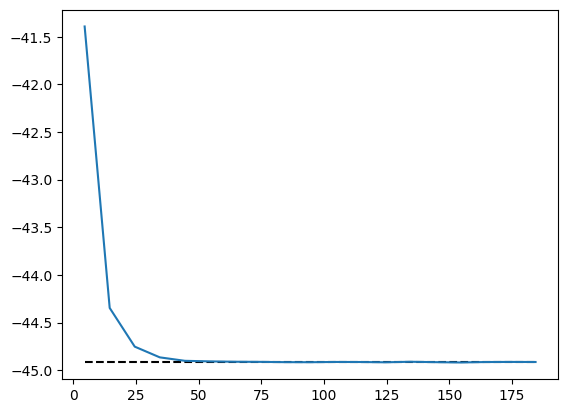

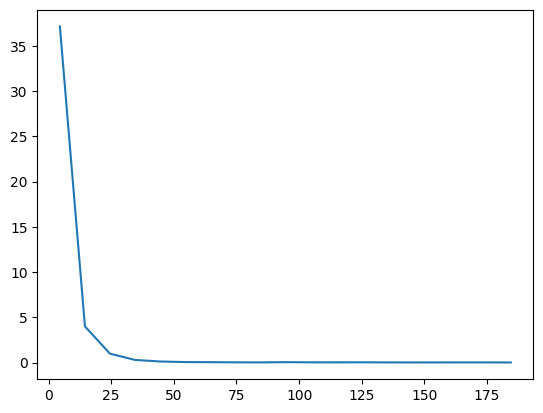

In [10]:
energy = qtx.utils.DataTracer()
VarE = qtx.utils.DataTracer()

training_rate = 0.01

for i in range(200):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state.update(step * training_rate)

    energy.append(optimizer.energy)
    VarE.append(optimizer.VarE)
    if i % 10 == 0:
        clear_output()
        energy.plot(batch=10, baseline=exact_energy)
        plt.show()
        VarE.plot(batch=10)
        plt.show()

Then we can save the trained model for reference in the future. Internally, we call [`equinox.tree_serialise_leaves`](https://docs.kidger.site/equinox/api/serialisation/#equinox.tree_serialise_leaves) to save the model.

In [11]:
state.save("/tmp/Heisenberg.eqx")

To get better accuracy, one can apply symmetry projections on the variational state. For a symmetry group $G$ with elememts $g$ and characters $\chi_g$, the projection is defined as

$$
\psi^\mathrm{symm}(s) = \sum_g \chi_g \psi(T_g s).
$$

In this system, the symmetry operation includes translation, rotation, mirror flip, and spin inverse. As the translation symmetry is already enforced in the convolutional network, we enforce the remaining symmetries by projection.

In [14]:
symm = Rotation(np.pi/2) @ Flip() @ SpinInverse()

symm_state = qtx.state.Variational(
    model, "/tmp/Heisenberg.eqx", symm, max_parallel=2048
)

sampler = qtx.sampler.SpinExchange(symm_state, nsamples=1024)
optimizer = qtx.optimizer.SR(symm_state, H)

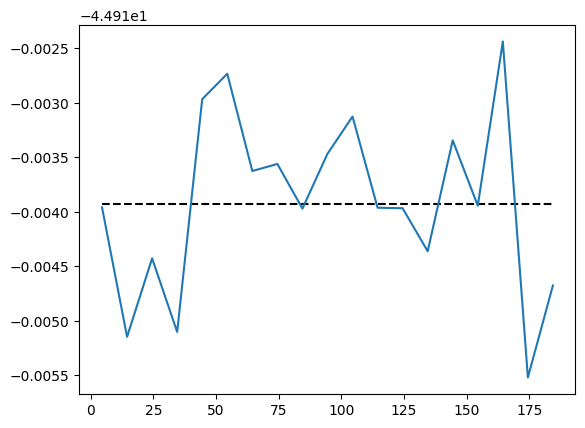

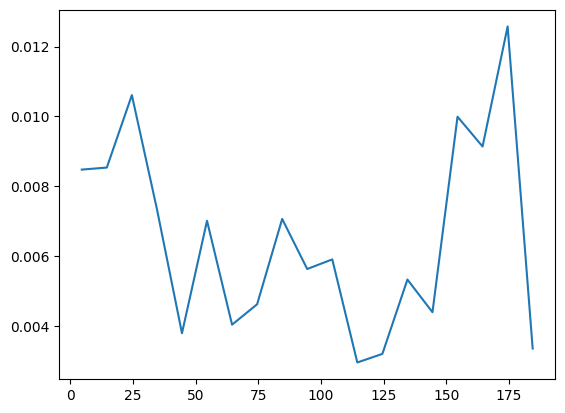

In [15]:
energy = qtx.utils.DataTracer()
VarE = qtx.utils.DataTracer()

training_rate = 0.01

for i in range(200):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state.update(step * training_rate)

    energy.append(optimizer.energy)
    VarE.append(optimizer.VarE)
    if i % 10 == 0:
        clear_output()
        energy.plot(batch=10, baseline=exact_energy)
        plt.show()
        VarE.plot(batch=10)
        plt.show()

state.save("/tmp/Heisenberg.eqx")

We can check the variational accuracy against the ED result.

In [16]:
dense = symm_state.todense(full_symm).normalize()
nqs_energy = jnp.asarray(dense @ H @ dense)
rel_err = jnp.abs((nqs_energy - exact_energy) / exact_energy)
print(f"NQS energy: {nqs_energy}, relative error: {rel_err}")

fidelity = jnp.abs(dense @ wf[:, 0]) ** 2
print(f"Fidelity: {fidelity}")

NQS energy: -44.91378949798582, relative error: 3.191342209012617e-06
Fidelity: 0.9999963531012662


## J1-J2 model

To enter the next level of complexity, we look at the $J_1$-$J_2$ model at the most frustrated regime $J_2/J_1=0.5$. In this case, the Marshal sign rule is still an approximate sign rule, but no longer exact. Nevertheless, defining a Hamiltonian with basis rotation still makes it easier to train a network.

In [17]:
H = qtx.operator.Heisenberg(J=[1, 0.5], n_neighbor=[1, 2], msr=True)

E, wf = H.diagonalize(full_symm)
exact_energy = E[0]
print(f"Exact ground state energy: {exact_energy}")

Exact ground state energy: -33.8316934055794


Now the wavefunction is no longer strictly positive but still real. To allow the network to produce negative outputs, we replace the defaul activation function in the last layer, $f(x)=\exp(x)$, by the new activation function $f(x) = \sinh(x) + 1$. To avoid overflow, it is implemented by [`sinhp1_by_scale`](https://chenao-phys.github.io/quantax/nn/quantax.nn.sinhp1_by_scale.html#quantax.nn.sinhp1_by_scale).

In [18]:
model = qtx.model.ResConv(
    nblocks=2, channels=8, kernel_size=3, final_activation=qtx.nn.sinhp1_by_scale
)

state = qtx.state.Variational(model, max_parallel=20000)
sampler = qtx.sampler.SpinExchange(state, nsamples=1024)
optimizer = qtx.optimizer.SR(state, H)

Then we can train as usual.

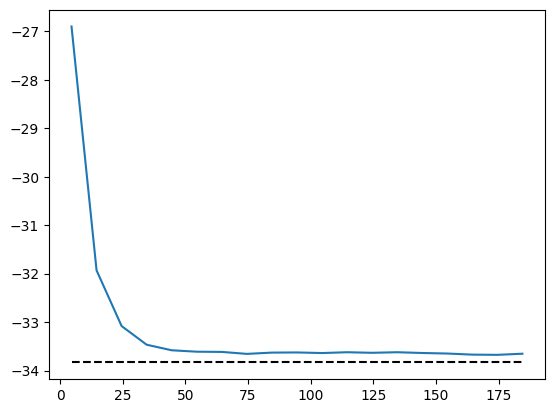

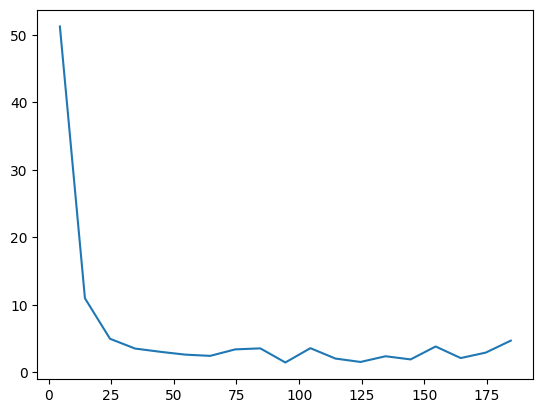

In [19]:
energy = qtx.utils.DataTracer()
VarE = qtx.utils.DataTracer()

training_rate = 0.01

for i in range(200):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    state.update(step * training_rate)

    energy.append(optimizer.energy)
    VarE.append(optimizer.VarE)
    if i % 10 == 0:
        clear_output()
        energy.plot(batch=10, baseline=exact_energy)
        plt.show()
        VarE.plot(batch=10)
        plt.show()

state.save("/tmp/J1J2.eqx")

It becomes harder to converge due to the sign structure. But we can still apply symmetries to improve the performance.

In [20]:
symm = Rotation(np.pi/2) @ Flip() @ SpinInverse()

symm_state = qtx.state.Variational(
    model, "/tmp/J1J2.eqx", symm, max_parallel=2048
)

sampler = qtx.sampler.SpinExchange(symm_state, nsamples=1024)
optimizer = qtx.optimizer.SR(symm_state, H)

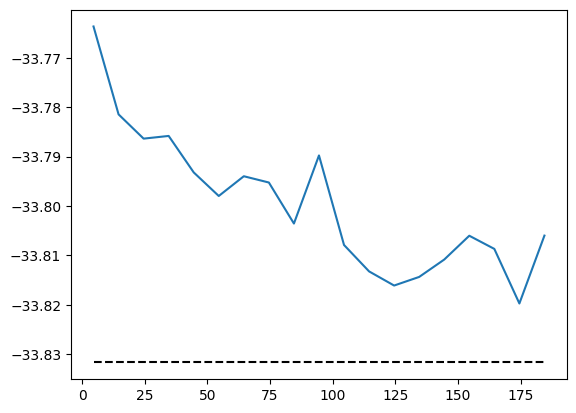

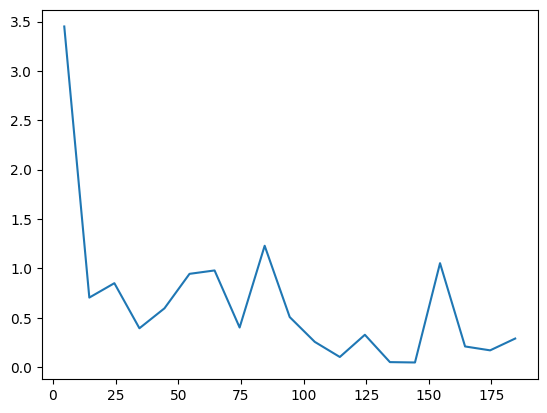

In [21]:
energy = qtx.utils.DataTracer()
VarE = qtx.utils.DataTracer()

training_rate = 0.01

for i in range(200):
    samples = sampler.sweep()
    step = optimizer.get_step(samples)
    symm_state.update(step * training_rate)

    energy.append(optimizer.energy)
    VarE.append(optimizer.VarE)
    if i % 10 == 0:
        clear_output()
        energy.plot(batch=10, baseline=exact_energy)
        plt.show()
        VarE.plot(batch=10)
        plt.show()

symm_state.save("/tmp/J1J2.eqx")

A benchmark against ED shows that the $J_1$-$J_2$ model is indeed more difficult than the nearest-neighbor Heisenberg model. The accuracy can be improved by increasing the amount of samples or utilizing deeper and wider networks.

In [22]:
dense = symm_state.todense(full_symm).normalize()
nqs_energy = jnp.asarray(dense @ H @ dense)
rel_err = jnp.abs((nqs_energy - exact_energy) / exact_energy)
print(f"NQS energy: {nqs_energy}, relative error: {rel_err}")

fidelity = jnp.abs(dense @ wf[:, 0]) ** 2
print(f"Fidelity: {fidelity}")

NQS energy: -33.80841893223185, relative error: 0.0006879488138098983
Fidelity: 0.9985234921056418
